In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from catboost import Pool

from google.colab import files

from feature_engine import categorical_encoders as ce

In [231]:
train=pd.read_csv("/content/drive/My Drive/hackathons/al demand forecasting/train_0irEZ2H.csv")
test=pd.read_csv("/content/drive/My Drive/hackathons/al demand forecasting/test_nfaJ3J5.csv")
submission_df=pd.read_csv("/content/drive/My Drive/hackathons/al demand forecasting/sample_submission_pzljTaX.csv")

In [232]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [233]:
train.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [234]:
def process(df):
  df["week"]=pd.to_datetime(df["week"],format="%d/%m/%y")
  df["year"]=df['week'].dt.year
  df["month"]=df["week"].dt.month
  df["day"]=df["week"].dt.day
  df["base_div_total"]=df["base_price"]/df["total_price"]
  df["both_ones"]=df["is_featured_sku"]*df["is_display_sku"]
  df["discount_or_not"]=df.apply(lambda x:0 if x["total_price"]>x["base_price"] else 1,axis=1)
  df["discounted_price"]=df["base_price"]-df["total_price"]
  df["discounted_price"]=df["discounted_price"].apply(lambda x:0 if x<0 else x)
  df["demand_price"]=df["total_price"]-df["base_price"]
  df["demand_price"]=df["demand_price"].apply(lambda x:0 if x<0 else x)
  df1=df.drop(columns=["record_ID","week"])



  return df1

In [235]:
train_process=process(train)
test_process=process(test)

In [236]:
def grp(train,test):
  # for j in ['store_id', 'sku_id','is_featured_sku','is_display_sku','year', 'month', 'day']:
  #     grp=train.groupby(j).agg({"units_sold":["mean"]})
  #     grp.columns=[i+"_"+j for i in ["mean"]]
  #     train=pd.merge(left=train,right=grp,on=j)
  #     test=pd.merge(left=test,right=grp,on=j)
  return train,test

In [237]:
train_grp,test_grp=grp(train_process,test_process)

In [238]:
train_grp.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,year,month,day,base_div_total,both_ones,discount_or_not,discounted_price,demand_price
0,8091,216418,99.0375,111.8625,0,0,20,2011,1,17,1.129496,0,1,12.825,0.0
1,8091,216419,99.0375,99.0375,0,0,28,2011,1,17,1.000000,0,1,0.000,0.0
2,8091,216425,133.9500,133.9500,0,0,19,2011,1,17,1.000000,0,1,0.000,0.0
3,8091,216233,133.9500,133.9500,0,0,44,2011,1,17,1.000000,0,1,0.000,0.0
4,8091,217390,141.0750,141.0750,0,0,52,2011,1,17,1.000000,0,1,0.000,0.0


In [239]:
X=train_grp.drop(columns=["units_sold"])
y=train_grp["units_sold"]

In [240]:
def feature_eng(train,test):

  cols=['store_id', 'sku_id','is_featured_sku','is_display_sku','year', 'month', 'day']

  for i in cols:
    train[i]=train[i].astype("object")
    test[i]=test[i].astype("object")

  encoder = ce.CountFrequencyCategoricalEncoder(encoding_method='frequency',
                         variables=cols)
  encoder.fit(train)
  # transform the data
  train_t=pd.DataFrame(data=encoder.transform(train)[cols].values,columns=[i+"_Freq_encode" for i in cols])
  train_return=pd.concat([train,train_t],axis=1)
  test_t=pd.DataFrame(data=encoder.transform(test)[cols].values,columns=[i+"_Freq_encode" for i in cols])
  test_return=pd.concat([test,test_t],axis=1)

  for i in cols:
    train_return[i]=train_return[i].astype("int64")
    test_return[i]=test_return[i].astype("int64")
  
  

  return train_return,test_return
  

In [241]:
train_final,test_final=feature_eng(X,test_grp)

In [242]:
train_final.head()

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,year,month,day,base_div_total,both_ones,discount_or_not,discounted_price,demand_price,store_id_Freq_encode,sku_id_Freq_encode,is_featured_sku_Freq_encode,is_display_sku_Freq_encode,year_Freq_encode,month_Freq_encode,day_Freq_encode
0,8091,216418,99.0375,111.8625,0,0,2011,1,17,1.129496,0,1,12.825,0.0,0.007792,0.058874,0.904389,0.8668,0.384615,0.1,0.030769
1,8091,216419,99.0375,99.0375,0,0,2011,1,17,1.000000,0,1,0.000,0.0,0.007792,0.058009,0.904389,0.8668,0.384615,0.1,0.030769
2,8091,216425,133.9500,133.9500,0,0,2011,1,17,1.000000,0,1,0.000,0.0,0.007792,0.057143,0.904389,0.8668,0.384615,0.1,0.030769
3,8091,216233,133.9500,133.9500,0,0,2011,1,17,1.000000,0,1,0.000,0.0,0.007792,0.064069,0.904389,0.8668,0.384615,0.1,0.030769
4,8091,217390,141.0750,141.0750,0,0,2011,1,17,1.000000,0,1,0.000,0.0,0.007792,0.060606,0.904389,0.8668,0.384615,0.1,0.030769


In [244]:
model=cb.CatBoostRegressor(task_type="GPU",max_depth=11,cat_features=['store_id', 'sku_id','is_featured_sku','is_display_sku'])

In [245]:
n_split = 5
kf = KFold(n_splits=n_split, random_state=1, shuffle=True)

In [248]:
model=cb.CatBoostRegressor(task_type="GPU",max_depth=11)
avg=[]
for idx, (train_index, valid_index) in enumerate(kf.split(train_final)):
  print("folds")
  y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
  X_train, X_valid = train_final.iloc[train_index,:], train_final.iloc[valid_index,:]
  _train = Pool(X_train, label=y_train)
  _valid = Pool(X_valid, label=y_valid)
  fit_model = model.fit(_train,
                        eval_set=_valid,
                        verbose=0
                      )
  pred = fit_model.predict(X_valid)
  results=mean_squared_error(y_valid, pred)
  print("mse=",results)
  avg.append(results)
print("mean",np.mean(avg))
print("std",np.std(avg,ddof=1))

folds
mse= 543.9553560328264
folds
mse= 473.44077874500624
folds
mse= 478.72367855481764
folds
mse= 537.4395349220234
folds
mse= 537.3386257530134
mean 514.1795948015374
std 34.93112729538313


In [249]:
model.fit(train_final,y)

Learning rate set to 0.1439
0:	learn: 55.5170459	total: 15.6ms	remaining: 15.6s
1:	learn: 51.7632954	total: 30.2ms	remaining: 15.1s
2:	learn: 48.7254296	total: 44.9ms	remaining: 14.9s
3:	learn: 46.1144243	total: 59.7ms	remaining: 14.9s
4:	learn: 43.9397911	total: 74.4ms	remaining: 14.8s
5:	learn: 42.1863402	total: 88.7ms	remaining: 14.7s
6:	learn: 40.6237743	total: 115ms	remaining: 16.3s
7:	learn: 39.4486760	total: 135ms	remaining: 16.8s
8:	learn: 38.2527953	total: 165ms	remaining: 18.1s
9:	learn: 37.3031623	total: 178ms	remaining: 17.7s
10:	learn: 36.6630500	total: 192ms	remaining: 17.3s
11:	learn: 36.0185411	total: 206ms	remaining: 16.9s
12:	learn: 35.3775424	total: 220ms	remaining: 16.7s
13:	learn: 34.7438599	total: 234ms	remaining: 16.5s
14:	learn: 33.9904968	total: 248ms	remaining: 16.3s
15:	learn: 33.5573473	total: 262ms	remaining: 16.1s
16:	learn: 33.2538054	total: 277ms	remaining: 16s
17:	learn: 32.6560179	total: 290ms	remaining: 15.8s
18:	learn: 32.3369885	total: 304ms	remaini

In [250]:
pred=model.predict(test_final)

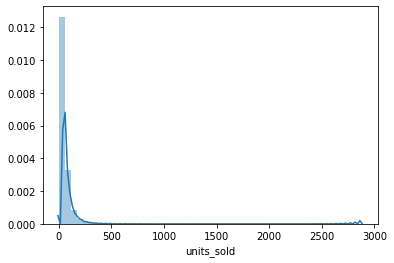

In [251]:
sns.distplot(train["units_sold"])

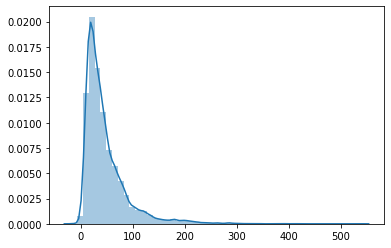

In [252]:
sns.distplot(pred)

In [253]:
submission_df["units_sold"]=pred

In [254]:
submission_df["units_sold"]=abs(submission_df["units_sold"])

In [255]:
submission_df.to_csv("submit12.csv",index=False)

In [256]:
files.download("submit12.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>